In [1]:
import nltk
import os
import re
import math
import pandas as pd
import numpy as np
import copy
import string
import random
import time
import itertools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import KMeans

(2225, 3)
[[ 0.74188726 -0.37755582 -0.55412534]
 [ 0.89226343 -0.05714913 -0.44788386]
 [ 0.84127322 -0.0138783  -0.54043201]
 ...
 [ 0.91252274 -0.12771443 -0.38857596]
 [ 0.89315029  0.05479731 -0.44640768]
 [ 0.85136673 -0.50207135  0.15198375]]


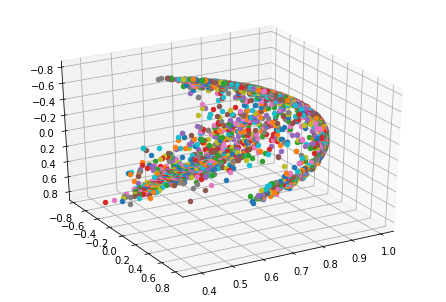

In [2]:
all_texts=[]
# os.chdir("C://Users//Hp//Desktop//Projects//Text Mining//bbcsport")
os.chdir("C://Users//Hp//Desktop//Projects//Text Mining//bbc")
directories = os.listdir()
for directory in directories:
    path = os.path.join(os.getcwd(),directory)
    os.chdir(path)
    files = os.listdir()
    temp = []
    for file in files:
        with open(file,'r') as curr_file:
            all_texts.append(curr_file.read()) 
    os.chdir('..')
tfidf = TfidfVectorizer(all_texts, stop_words='english')
vectors = tfidf.fit_transform(all_texts)
all_words = tfidf.get_feature_names()
vectors_dense = vectors.todense()
svd = TruncatedSVD(n_components=3)
vectors_dense_svd = svd.fit_transform(vectors_dense)
vectors_dense_svd = Normalizer().fit_transform(vectors_dense_svd)
print(vectors_dense_svd.shape)
fig=plt.figure()
ax = Axes3D(fig)
X = vectors_dense_svd
print(X)
for j in range(len(X)):
    ax.scatter(X[j][0], X[j][1], X[j][2], marker='o')
    ax.view_init(330, 120)

In [3]:
K=5
P=30
cross_over_rate=0.1
mutation_rate=0.01

In [4]:
def population_initialization():
    '''
    Parameters:
    Output:
        P chromosomes of length K*N where N is the number of features
    Function:
        Takes K random datapoints from the dataset and appends them to create a chromosome
        This is repeated P times
    '''
    population=[]
    for i in range(P):
        chromosome=[]
        for j in range(K):
            chromosome.append(X[random.randint(0,len(X)-1)])
        chromosome=list(itertools.chain(*chromosome))
        population.append(chromosome)
    return population

In [5]:
#Function to decide cluster using Euclidean distance
def cosine_similarity(centers,datapoint):
    '''
    Parameters:
        centers: List of Cluster centers
        K : number of clusters
        datapoint : Datapoint
    Output:
        Cluster number alloted based on maximum cosine_similarity of the datapoint with the cluster centers
    '''
    #Cosine Similarity    
    t = np.asarray(datapoint)
    normt= np.linalg.norm(t)
    dot=[]
    for i in range(K):
        temp_center = np.asarray(centers[i])
        normc = np.linalg.norm(temp_center)
        cos_sim_value=np.dot(t,temp_center)/(normt*normc)
        dot.append(cos_sim_value)
    
    return dot.index(max(dot))

In [6]:
def euclidean_dist_based_center_decision(centers,datapoint):
    t = np.asarray(datapoint)
    dist=[]
    for i in range(K):
        temp_center = np.asarray(centers[i])
        dist.append(np.sqrt(np.sum(np.square(temp_center-t))))
    return dist.index(min(dist))

In [7]:
def fitness_function(chromosome):
    '''
    Parameters:
        K: Number of clusters
        chromosome: Contains the centers of K clusters
        X : dataset
    Output:
        A fitness value f for the input chromosome
    Function:
        1. Initializes K centers using the chromosome
        2. Divides the dataset into K clusters using functions like cosine_similarity or euclidean_distance
        3. Recomputer cluster centers by averaging the datapoints of that cluster
        4. Computer fitness value as follows:
                M = sum from i in range(1,K)(Mi)
                Mi= sum of distances of datapoints of a cluster from its center
                fitness_value(f) = 1/M
    '''
    centers=[]
    
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(chromosome[i*len(X[0]):len(X[0])*(i+1)])
    
    #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
#         clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])
        clusters[cosine_similarity(centers,X[i])].append(X[i])
    
    n_components=2
    svd = TruncatedSVD(n_components)
    U  = []
    for i in range(K):
        if(len(clusters[i])!=0):
            U.append(svd.fit_transform(clusters[i]))
    
    theta=0
    for i in range(n_components):
        for j in range(len(U)):
            for k in range(len(U)):
                if k!=j and (U[k].shape)[1]==(U[j].shape)[1]:
                    t1 = U[j][i]
                    t2 = U[k][i]
                    temp = np.dot(t1,t2)/(np.linalg.norm(t1)*np.linalg.norm(t2))
                    theta=theta+math.acos(temp)
        
    #Recomputing cluster centers
    centers=[]
    for i in range(K):
        temp=clusters[i]
        if len(temp)!=0:
            centers.append((np.sum(np.asarray(temp),axis=0)/len(temp)).tolist())
        else:
            temp_list=X[random.randint(0,len(X)-1)]
            centers.append(temp_list)
    
    chromosome =[]
    for i in range(len(centers)):
        chromosome.extend(centers[i])
    fitness_score = theta
    return fitness_score,chromosome        

In [8]:
def fitness_evaluation(population):
    '''
    Parameters:
        K: Number of clusters
        population: Contains all the chromosomes of the current generation
        X : dataset
    Output:
        A list of fitness scores of each chromosome in the parent
    '''
    fitness=[]
    pop = []
    for i in population:
        fitness_value,recomputed_chromosome = fitness_function(i)
        fitness.append(fitness_value)
        pop.append(recomputed_chromosome)
    return pop,fitness

In [9]:
def roulette_wheel(fitness_scores):
    sum_fitness_scores = np.sum(np.asarray(fitness_scores))
    temp_fitness = copy.deepcopy(fitness_scores)
    temp_fitness.sort(reverse=True)
    t=[]
    for i in range(len(fitness_scores)):
        percentage_coverage=int(temp_fitness[i]*360/sum_fitness_scores)
        for j in range(percentage_coverage):
            t.append(i)
    
    temp=[]
    for i in range(2):
        toss=random.randint(0,len(t)-1)
        temp.append(t[toss])
    return temp

In [10]:
def cross_over(parent1,parent2,parent1_f_val,parent2_f_val):
    temp = {}
    fitness_scores=[]
    fitness_scores.append(parent1_f_val)
    fitness_scores.append(parent2_f_val)
    temp[parent1_f_val]=parent1
    temp[parent2_f_val]=parent2
    for i in range(1,len(parent1)-1):
        prob_of_cross_over_point = np.random.random_sample()
        if prob_of_cross_over_point<cross_over_rate:
            left_parent_1 = parent1[:i]
            right_parent_1= parent1[i:]
            left_parent_2 = parent2[:i]
            right_parent_2= parent2[i:]
            child1 = left_parent_1
            child2 = left_parent_2
            child1.extend(right_parent_2)
            child2.extend(right_parent_1)
            _,fitness_values = fitness_evaluation([child1,child2])
            temp[fitness_values[0]]=child1
            temp[fitness_values[1]]=child2
            fitness_scores.extend(fitness_values)
    max1=max(fitness_scores)
    fitness_scores.remove(max1)
    max2=max(fitness_scores)
    return temp[max1],temp[max2]

In [11]:
def cross_over_function(population,fitness_scores):
    '''
    Parameters:
        population: Parent population chromosomes
        fitness_scores: fitness of parent population
    Output:
        children generation population
    Function:
        We select the 2 best chromosomes and 2 worst chromosomes and perform a cross-over between the bests and worsts and add
        them to the population generating children generation population with 4 different chromosomes.
    '''
    for i in range(P//2):
        t=roulette_wheel(fitness_scores)
        t.sort()
        c1i,c2i=t[0:2]
        chromosome1 = population[c1i]
        chromosome2 = population[c2i]

        c1,c2 = cross_over(chromosome1,chromosome2,fitness_scores[c1i],fitness_scores[c2i])

        population.append(c1)
        population.append(c2)

        del(population[c1i])
        del(fitness_scores[c1i])
        c2i=max(0,c2i-1)
        del(population[c2i])
        del(fitness_scores[c2i])

        t,fitness = fitness_evaluation([c1,c2])
        fitness_scores.extend(fitness)
    return population,fitness_scores

In [12]:
def mutation(children):
    '''
    Parameters:
        children: Children we get from the genetic cross-over in the previous stage
        mutation_rate: Rate at which we want to mutate the children (0-1)
    Output:
        children with a mutated gene
    Functions:
        We randomly select a number between 0 and 1 using probably a gaussian distribution as mutation is not a frequent
        phenomenon. If that value is less than mutation_rate we mutate the children.
        For mutation we again generate a value alpha between 0 to 1. We then randomly select a position from the chromosome
        and changes its value as following
            let the value at the randomly selected position be v
            v = v (+/-) 2*alpha*v if(v!=0)
            v = v (+/-) 2*alpha   if(v==0)
        (+/-) is selected randomly giving each a 50-50 chance
    '''
    for i in range(len(children)):
        temp = np.random.rand(1)[0]
        if temp<mutation_rate:
            chromosome = children[i]
            position = random.randint(0,len(chromosome)-1)
            chromosome[position]=abs(1-chromosome[position])
            children[i]=chromosome
            
    return children

In [13]:
def intracluster_distances(chromosome):
    centers=[]
    
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(chromosome[i*len(X[0]):len(X[0])*(i+1)])
    
    #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
#         clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])
        clusters[cosine_similarity(centers,X[i])].append(X[i])
   
    intracluster_d=[]
    for i in range(K):
        M=0
        temp=clusters[i]
        center=centers[i]
        for j in temp:
            M+=np.linalg.norm(np.asarray(j)-np.asarray(center))
        if len(temp)==0:
            M=0
        else:
            M=M/len(temp)
        intracluster_d.append(M)
    return intracluster_d

In [14]:
def davies_bouldin_index(chromosome):
    intra_distance = intracluster_distances(chromosome)
    
    centers=[]
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(chromosome[i*len(X[0]):len(X[0])*(i+1)])
    
    D = []
    for i in range(K):
        R = []
        for j in range(K):
            if i!=j:
                M = np.linalg.norm(np.asarray(centers[i])-np.asarray(centers[j]))
                r = (intra_distance[i]+intra_distance[j])/M
                R.append(r)
        D.append(max(R))
    return (1/K)*(np.sum(np.asarray(D)))

In [15]:
def silhoutette_index(chromosome):
    centers=[]
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(chromosome[i*len(X[0]):len(X[0])*(i+1)])
        
    #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
        clusters[cosine_similarity(centers,X[i])].append(X[i])
#         clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])

    S = 0
    for i in range(K):
        for j in clusters[i]:
            a = 0
            b = 0
            t1 = np.asarray(j)
            for k in clusters[i]:
                t2 = np.asarray(k)
                a  = a + np.sqrt(np.sum(np.square(t1-t2)))
            for k in range(K):
                if i!=k:
                    for f in clusters[k]:
                        t2 = np.asarray(f)
                        b  = b + np.sqrt(np.sum(np.square(t1-t2)))
            s = abs(a-b)/max(a,b)
            S = S + s
    S = S/len(X)
    return S

In [16]:
def dunn_index(chromosome):
    centers=[]
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(chromosome[i*len(X[0]):len(X[0])*(i+1)])
        
    #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
        clusters[cosine_similarity(centers,X[i])].append(X[i])
#         clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])
    
    numerator = 10000000
    denominator=1
    for i in range(K):
        for j in range(K):
            if i!=j:
                numerator = min(numerator, np.sqrt(np.sum(np.square(np.asarray(centers[i])-np.asarray(centers[j])))))
    
    denominator = max(intracluster_distances(chromosome))
    return numerator/denominator

In [17]:
def main_func():
    '''
    Steps:
    Repeat 1-5 till 1 chromosome remains in the population
    1.Initialize Population
    2.Compute fitness scores
    3.Selection
    4.Cross-over
    5.Mutation
    '''
    population = population_initialization()
    gen=0
    return_chromosome=[]
    for i in range(100):
        gen+=1
        population,fitness=fitness_evaluation(population)
        children,fitness = cross_over_function(population,fitness)
        children = mutation(children)
        population=children
#         centers=[]
#         purity = 100000
#         for j in population:
#             temp = min(purity,davies_bouldin_index(j))
#             if temp!=purity:
#                 purity=temp
#                 return_chromosome=j
#         print("Generation: "+str(gen)+" | Purity: "+str(purity))
    return population[fitness.index(max(fitness))]

In [18]:
def plot(chromosome):
    centers=[]
    
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(chromosome[i*len(X[0]):len(X[0])*(i+1)])
    
    #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
        clusters[cosine_similarity(centers,X[i])].append(X[i])
#         clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])
    
    for i in range(K):
        print(len(clusters[i]))
    colors=['r','m','y','k','c']
    fig=plt.figure()
    ax = Axes3D(fig)
    for i in range(K):
        temp=clusters[i]
        for j in temp:
            ax.scatter(j[0], j[1], j[2], c=colors[i], marker='o')
            ax.view_init(330, 120)
    for i in range(K):
        temp=clusters[i]
        ax.scatter(centers[i][0],centers[i][1],centers[i][2],c='b',marker='X')

C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: divide by zero encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


DB Index        :1.8461340265082384
Silhoutte Index :0.8907767931102939
Dunn Index      :0.6038301660348617
209
798
370
229
619


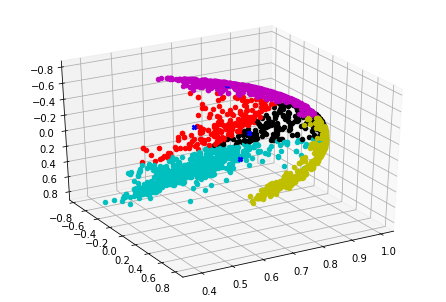

In [19]:
chromosome = main_func()
print("DB Index        :"+str(davies_bouldin_index(chromosome)))
print("Silhoutte Index :"+str(silhoutette_index(chromosome)))
print("Dunn Index      :"+str(dunn_index(chromosome)))
plot(chromosome)